In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn import datasets
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from groufi import group_permutation_importance

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (16, 8)

## Create a synthetic dataset

Create a synthetic regression dataset of 10k examples. Each example is represented by a 20-dimensional vector, where only 10 features are informative. The other 10 features are not necessary to make accurate predictions. Each target is a scalar value. The target is generated by applying a random linear regression model with on the 10 informative features.

In [3]:
X, y, coef = datasets.make_regression(n_samples=10000, n_features=20, n_informative=10, n_targets=1, coef=True, random_state=1)
print('X', X.shape, 'y', y.shape, 'coef', coef.shape)

X (10000, 20) y (10000,) coef (20,)


Simulate some correlated features. By default, the features are not correlated. 

In [4]:
# Add correlated features
indices = np.argsort(coef, axis=0)[::-1]
print(indices)
X1 = np.reshape(0.1 * X[:, indices[4]] + 0.9 * X[:, indices[0]], newshape=(-1, 1))
X2 = np.reshape(0.8 * X[:, indices[4]] + 0.2 * X[:, indices[0]], newshape=(-1, 1))
X3 = np.reshape(0.9 * X[:, indices[1]] + 0.1 * X[:, indices[3]], newshape=(-1, 1))
X = np.concatenate([X, X1, X2, X3], axis=1)
coef = np.concatenate([coef, -np.ones((3,))])
print('X', X.shape, 'coef', coef.shape)

[ 2 13  9  3  1 15 10 14  8  6  4  5 19  7 18 11 12 16 17  0]
X (10000, 23) coef (23,)


Show the correlation matrix of the features

<AxesSubplot:>

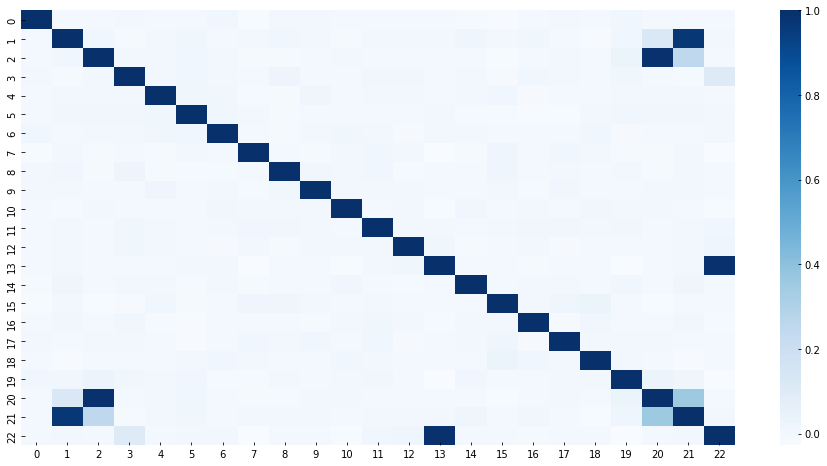

In [5]:
# Correlation matrix
correlation = np.corrcoef(X, rowvar=False)
sb.heatmap(correlation, cmap="Blues")

Generate artificial feature names 

In [6]:
feature_names = [f'f{i}' for i in range(X.shape[1])]
df_coef = pd.DataFrame(data={'coef': coef}, index=feature_names)

Split the data into training/testing sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Preprocess the data

In [8]:
scaler_X = RobustScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

## Model training and evaluation

Define a MLP regression model and train it on the training dataset.

In [9]:
model = MLPRegressor(hidden_layer_sizes=(64, 64,), max_iter=1000, random_state=1)
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=1)

Compute predictions on the test set

In [10]:
y_pred = model.predict(X_test)
print('Y_pred', y_pred.shape)

Y_pred (2500,)


Evaluate some metrics on the test set

In [11]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 0.00
Coefficient of determination: 1.00


## Feature importance

### Feature importance by taking into account the feature correlation

**How to interpret the result.** The `group_permutation_importance` function returns a `pandas.DataFrame` with 3 columns:

- `Feature Importance`: This column indicates the estimated feature importance by using permutations of correlated feature group. 
- `group`. This column indicates all the features that are permutted together to compute the feature permutation importance of this feature. For example, the first line indicates that `f2` and `f20` are permutted together to compute the feature permutation importance of `f2`.
- `coef`. This column indicates the importance of each feature in the output creation. `-1` indicates a feature that was added after the dataset creation.

It is possible to compare the feature importance and the group columns. Ideally, a feature with a high coefficient should have a high feature importance. 
In this example, we can see the ranking of the features by decreasing order of `Feature Importance` is very similar to the ranking of the features by decreasing order of `coef`. 
Note that `coef=-1` is a special value to indicate an added correlated feature.
It shows the group premutation importance was able to estimate accurately the importance of each feature. 
By construction, two correlated features have the same estimated feature importance. 

In [12]:
df_gfi = group_permutation_importance(
    estimator=model,
    features=X_test,
    feature_names=feature_names,
    threshold=0.75,
    random_state=42,
)
df_gfi['coef'] = df_coef['coef']
df_gfi

,Feature Importance,group,coef
f2,4.817160e-01,"(2, 20)",97.220679
f20,4.817160e-01,"(2, 20)",-1.000000
f22,3.911620e-01,"(13, 22)",-1.000000
f13,3.911620e-01,"(13, 22)",78.606030
f9,3.323564e-01,"(9,)",72.159402
f3,2.147543e-01,"(3,)",62.499545
f21,1.604217e-01,"(1, 21)",-1.000000
f1,1.604217e-01,"(1, 21)",54.075224
f15,1.271698e-01,"(15,)",45.455979
f10,9.248727e-02,"(10,)",39.362088


### Feature importance by ignoring feature correlation

The following result assumes the features are independent. Each feature dimension is permuted independently to compute the feature permutation importance. The indepence assumption is simluated by setting `threshold=0.99999`. 
The `group` column in the generated DataFrame shows that only one feature is permutted at a time. 
In this example, we can see the ranking of the features by decreasing order of `Feature Importance` is quote different of the ranking of the features by decreasing order of `coef`. 
The feature with the highest `coef` value (`f2`) has the third highest feature importance value, and the feature with the second highest `coef` value (`f13`) has the seventh highest feature importance value.
It shows the feature permutation importance method was not able to correctly estimate the feature importance.
The feature importance of correlated features is shared between these features. 

In [13]:
df_gfi = group_permutation_importance(
    estimator=model,
    features=X_test,
    feature_names=feature_names,
    threshold=0.99999,
    random_state=42,
)
df_gfi['coef'] = df_coef['coef']
df_gfi

,Feature Importance,group,coef
f9,3.323564e-01,"(9,)",72.159402
f3,2.147543e-01,"(3,)",62.499545
f2,1.354078e-01,"(2,)",97.220679
f15,1.271698e-01,"(15,)",45.455979
f20,1.071840e-01,"(20,)",-1.000000
f22,1.032405e-01,"(22,)",-1.000000
f13,9.327594e-02,"(13,)",78.606030
f10,9.248727e-02,"(10,)",39.362088
f21,7.431468e-02,"(21,)",-1.000000
f14,5.091193e-02,"(14,)",28.567495
